In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
# Perceptrons

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

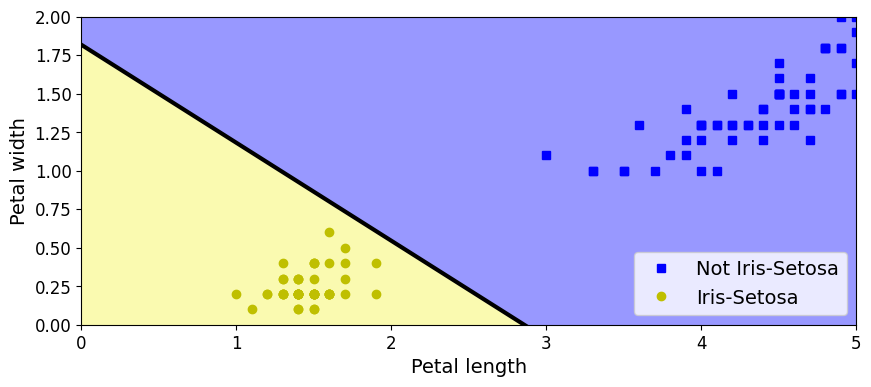

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

In [5]:
# Activation functions:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)


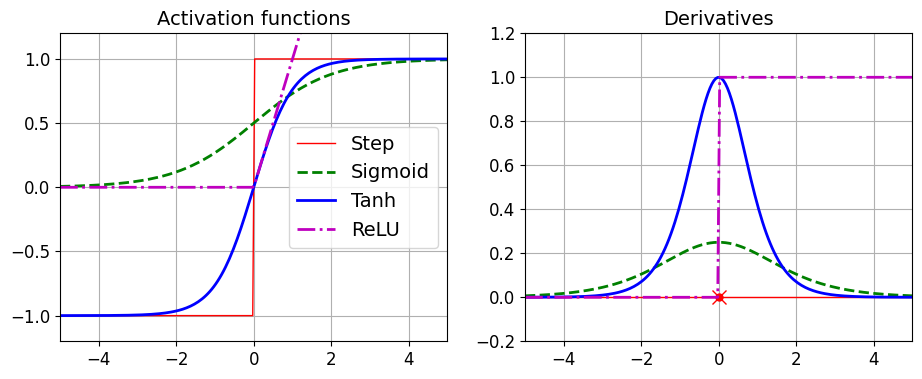

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

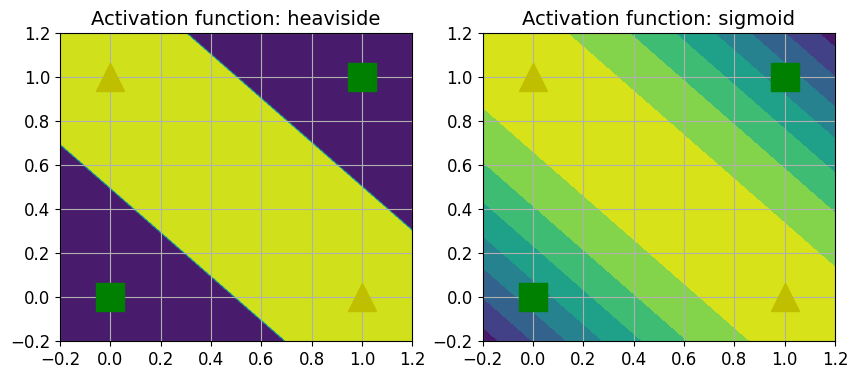

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

In [9]:
# Perceptron class is equivalent to Stochastic Gradient Descent with following hyper param:
# loss="percetron", learning_rate="constant", eta0=1 (learning rate), pentalty=None (no regularization)

# Perceptrons do not output a class probabilities, but make predictions based on a hard threshold (Logistic Regression better for this case)

# One preceptron is a linear classification model - downside - cannot solve trivial problems such as XOR logic
# However, some of the limitations can be eliminated by stacking multiple perceptrons together -> Multi-Layer Perceptrons (MLP)
# - can solve XOR problem

In [10]:
# Multi-Layer Perceptron (MLP) and Backpropagation (TLU - threshold logic unit)

# Backpropagation training algorithm:
# - basically a Gradient Descent using an efficient technique for computing the gradients automatically
# - in just two passes (forward and backward) - can compute the gradient of the network's error w.r.t. every single model parameter
# -> how each connection weight and bias term should be tweaked to reduce the error
# - then just performs a regular Gradient Descent step to tweak the weights
# -> repeat until convergence

# Many methods to compute gradients automatically - one used here colled reverse-mode autodiff
# - fast and precise - well suited when the function to differentiate has manny variables (e.g. connection weights) and a few outputs (one loss)
# - description on page 287,288

# It is importnat to initialize the hidden layers' weights randomly
# - if all of them are the same, e.g. all weights/biases=0, then back propagation will affect them all exactly the same, so they remain identical

# For backprogagation to work - new activation function
# - replaced step function with the logistic function - adds gradient for Gradient Descent
# - function needs to be continuous and differentiable
# - many options exist

In [11]:
# Regression MLPs
# - generally do not want to use an activation function for an output neuron - should be free to output any range of values
# - but can put some restrictions, e.g. if you want an output to only be positive - ReLU function
# - logistic function/hyperbolic tangent - can be used for predictions to fall into a given range by scaling to the appropriate range

# Loss is usually mean squared error
# - Mean absolute error can also be used, especially if you have a lot of outliers in the training set
# - Huber loss - combination of both

In [12]:
# Classification MLPs
# - for binary classification - just need one output neruon with logistic activation function - number between 0 - 1 (e.g. estimated probability of positive class)
# - multilabel binary classification tasks - more output neruons necessary - 1 per binary label for positive class
#   - output probabilities do not necessarily add up to 1 - allows the model to outout any combination of labels

# Multiclass classification
# in the case each instance belongs only to a single class, out of 3 or more - e.g. number classification (0 - 9)
# - need to have one output neuron peer class, with softmax activation function for the whole output layers 
#  -> ensures that all the estimated probabilities are between 0 and 1 and they add up to 1, required when the classes are exclussive

# When predicting probabilitiy distributions - cross-entropy is generally a good choice

In [13]:
# Keras
from tensorflow import keras
tf.__version__

'2.18.0'

In [14]:
keras.__version__

'3.7.0'

In [15]:
# Image Classifier using Sequential API - Fashion MNIST dataset - 10 fashion items\
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [16]:
X_train_full.shape

(60000, 28, 28)

In [17]:
X_train_full.dtype

dtype('uint8')

In [18]:
# Creatming validation set
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_test = X_test / 255.

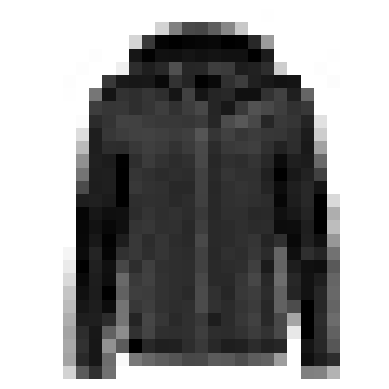

In [19]:
# Display one item:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [20]:
# The labels are the class IDs (represented as uint8), from 0 to 9:
y_train
# Let's give them names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

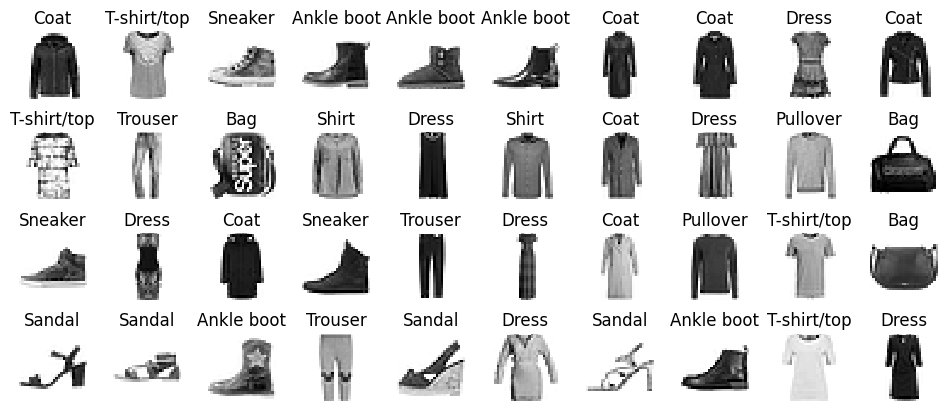

In [21]:
# Display samples from the dataset:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [22]:
# Creating the Model using Sequntial API
# simplest kind of Keras model - single stack of layers connected sequentially
model = keras.models.Sequential()
# converts each input image into 1D array - input X -> output X.reshape(-1,1)
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# add hidden layers with actiovation function, each Dense layer manages its own weight matrix and bias term
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
# output layer
model.add(keras.layers.Dense(10, activation="softmax"))

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Another way to pass a list of layers:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model.layers

[<Flatten name=flatten_1, built=True>,
 <Dense name=dense_3, built=True>,
 <Dense name=dense_4, built=True>,
 <Dense name=dense_5, built=True>]

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

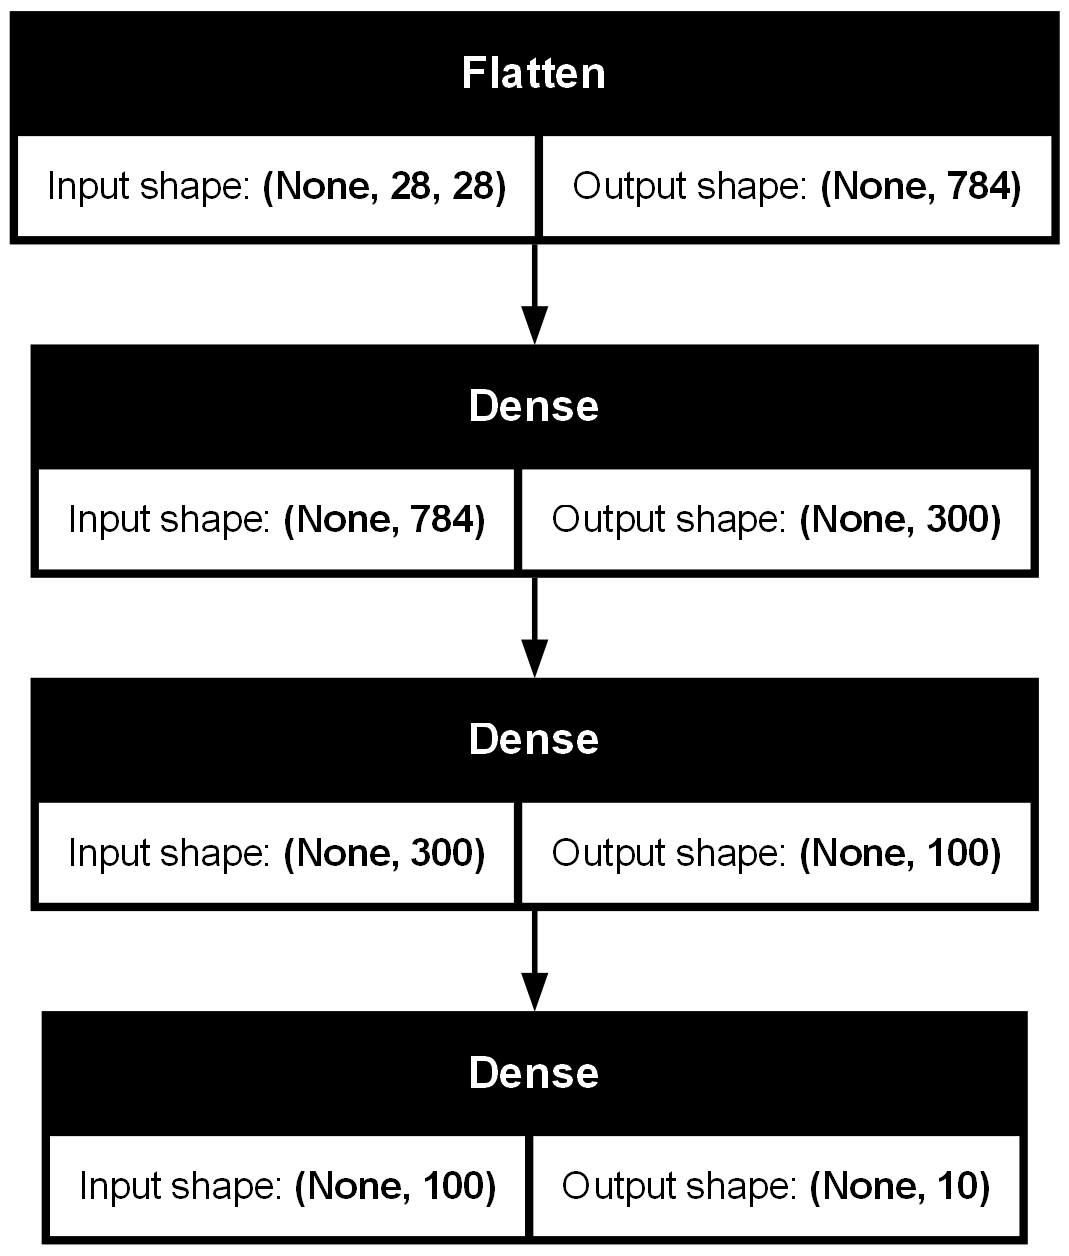

In [25]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [26]:
# Accessing the model's parameters such as layers and weights

In [27]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [28]:
weights, biases = hidden1.get_weights()
weights
# Initialized with random weights to break symmetry, biases are just 0 at the start
# kernel_initializer can be used for a different initialization method

array([[-0.06020981, -0.03747301, -0.0414211 , ...,  0.01256521,
         0.05166656, -0.04376124],
       [-0.05471505, -0.01680215, -0.03325102, ...,  0.0493386 ,
         0.04460938,  0.05503844],
       [ 0.02564053, -0.02432532, -0.02039374, ..., -0.00646933,
        -0.0504839 ,  0.05340301],
       ...,
       [ 0.04919659,  0.04674049,  0.0422667 , ...,  0.05450764,
        -0.03658872, -0.00995505],
       [ 0.03860912, -0.04876906, -0.03773024, ...,  0.06683941,
        -0.05172536,  0.04849096],
       [-0.05259549, -0.01919246, -0.02589656, ...,  0.01557124,
        -0.02826254,  0.01194201]], dtype=float32)

In [29]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)


In [30]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
# - sparce_cat... - sparse labels - each instance just a target class index - 0 to 9, exclusive
# -- e.g. for one target probability per class, 0,0,0,1,0,0,0,0,0,0 --> categorical_crossentropy
# ---> keras.utils.to_categorical() - convers sparse labels to one-hot vector labels
# - sgd - stochastic gradient descent
# - designing a classifier - want to measure its accuracy for training and evaluation

In [31]:
# Training and evaluation
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6824 - loss: 1.0148 - val_accuracy: 0.8346 - val_loss: 0.4921
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8235 - loss: 0.5010 - val_accuracy: 0.8520 - val_loss: 0.4404
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8419 - loss: 0.4512 - val_accuracy: 0.8522 - val_loss: 0.4310
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8528 - loss: 0.4189 - val_accuracy: 0.8646 - val_loss: 0.3987
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8618 - loss: 0.3942 - val_accuracy: 0.8570 - val_loss: 0.4109
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8654 - loss: 0.3834 - val_accuracy: 0.8686 - val_loss: 0.3735
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8719 - loss: 0.3643 - val_accuracy: 0.8702 - val_loss: 0.3670
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8750 - loss: 0.3542 - 

In [32]:
# History object contains training parameters, list of epoch and 
# dictionary (history.history) - has loss and extra metrics it measured at the end of each epoch
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


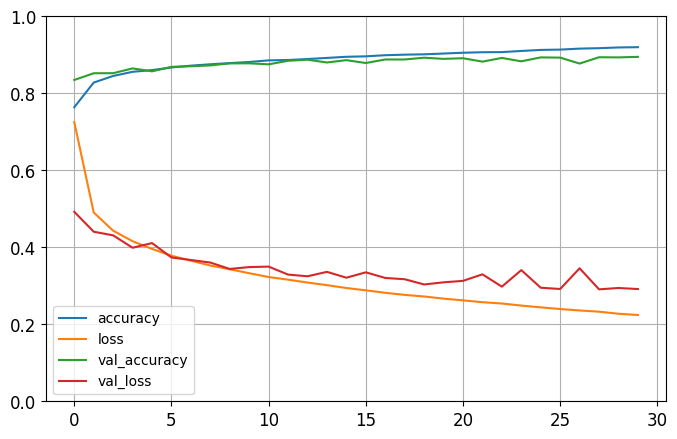

In [33]:
# With Pandas DataFrame you can call its plot() method to visualize the learning curves
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [34]:
# Evaluation
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8839 - loss: 0.3294


[0.32219061255455017, 0.8847000002861023]

In [35]:
# Making predictions
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [36]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([9, 2, 1])

In [37]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

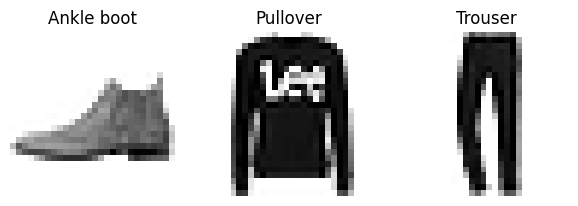

In [38]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [39]:
#  Building a Regression MLP using Sequenctial API
# trying to predict california housing prices
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [40]:
# Main difference from MLP classifier - output layer is a single neuron (only want one value) with
# no activation function, and loss is mean squared error
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8258 - val_loss: 1.2422
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8938 - val_loss: 0.7141
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7274 - val_loss: 0.6409
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6737 - val_loss: 0.5938
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6372 - val_loss: 0.5603
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6078 - val_loss: 0.5334
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5833 - val_loss: 0.5115
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5627 - val_loss: 0.4933
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5454 - val_loss: 0.4789
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5310 - val_loss: 0.4671
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5188 - val_loss: 0.4578
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

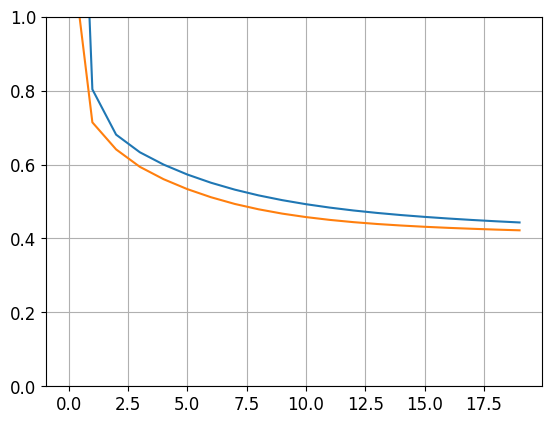

In [41]:
# Data is quite noisy - single hidden layer with fewer newrons than before to avoid overfitting
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [42]:
y_pred

array([[0.53906286],
       [1.6724193 ],
       [3.1871457 ]], dtype=float32)

In [43]:
# Complex model using the functional API - when they have complex topologies, e.g. multiple inputs and/or multiple outputs
# - e.g. Wide & Deep neural network - connects all parts of the inputs directly to the output layer
#        - can learn deep patterns and simple rules (simple patterns may end up distorted in regular MLPs)

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [45]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 8)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 30)                │             270 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 30)                │             930 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 38)                │               0 │ input_layer_3[0][0],       │
│                               │                           │                 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 1)                 │              39 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(None, 8))
  warnings.warn(msg)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7159 - val_loss: 10.4269
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7136 - val_loss: 1.2364
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6190 - val_loss: 0.5456
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5702 - val_loss: 0.4973
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5362 - val_loss: 0.4688
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5088 - val_loss: 0.4517
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4870 - val_loss: 0.4385
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4695 - val_loss: 0.4293
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4557 - val_loss: 0.4223
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4448 - val_loss: 0.4173
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4360 - val_loss: 0.4139
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(3, 8))
  warnings.warn(msg)


In [47]:
# Now what if you want to send a subset of features through the wide path and a different thhrough the deep path?
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [48]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deep_input (InputLayer)       │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 30)                │             210 │ deep_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ wide_input (InputLayer)       │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 30)                │             930 │ dense_11[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 35)                │               0 │ wide_input[0][0],          │
│                               │                           │                 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 1)                 │              36 │ concatenate_1[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,176 (4.59 KB)

 Trainable params: 1,176 (4.59 KB)

 Non-trainable params: 0 (0.00 B)

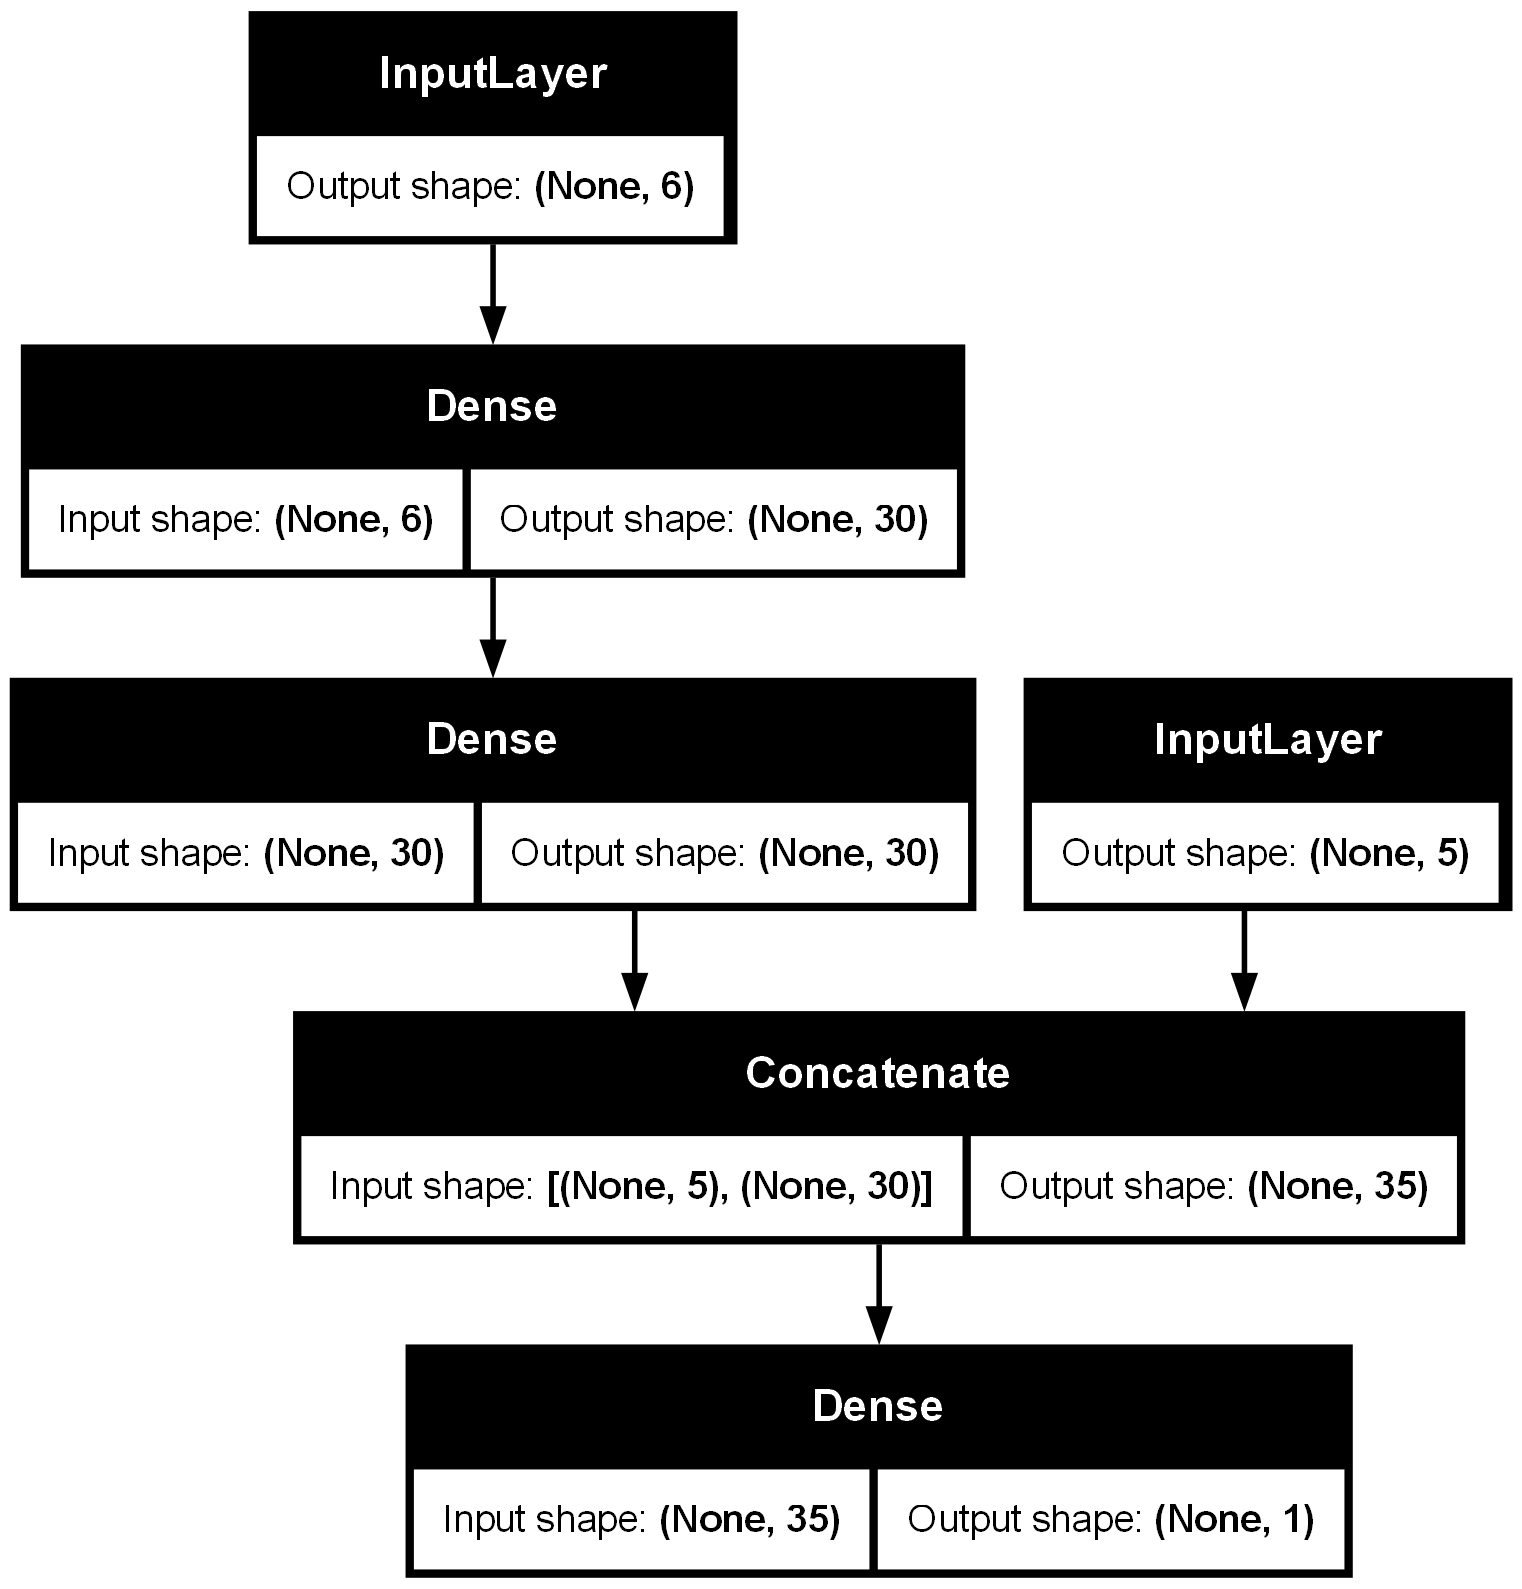

In [49]:
keras.utils.plot_model(model, "wide_deep_model.png", show_shapes=True)

In [50]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5754 - val_loss: 1.0673
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9190 - val_loss: 0.7082
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7246 - val_loss: 0.6068
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6358 - val_loss: 0.5491
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5815 - val_loss: 0.5089
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5442 - val_loss: 0.4793
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5174 - val_loss: 0.4572
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4979 - val_loss: 0.4404
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4833 - val_loss: 0.4283
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4723 - val_loss: 0.4190
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4637 - val_loss: 0.4117
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [51]:
# Note that the input now must be a pair of matrices - X_train_A and X_train_B - one per input,
# same for X_valid and X_test/X_new when evaluating and predicting

In [52]:
# In many cases multiple outputs at different stages are very useful:
# - e.g. locate and classify the object, multiple independent tasks - can use one network
# - or for regularization (reduce overfitting) - auxiliary outputs in NN to ensure the underlying part learns something useful on its own

np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [53]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

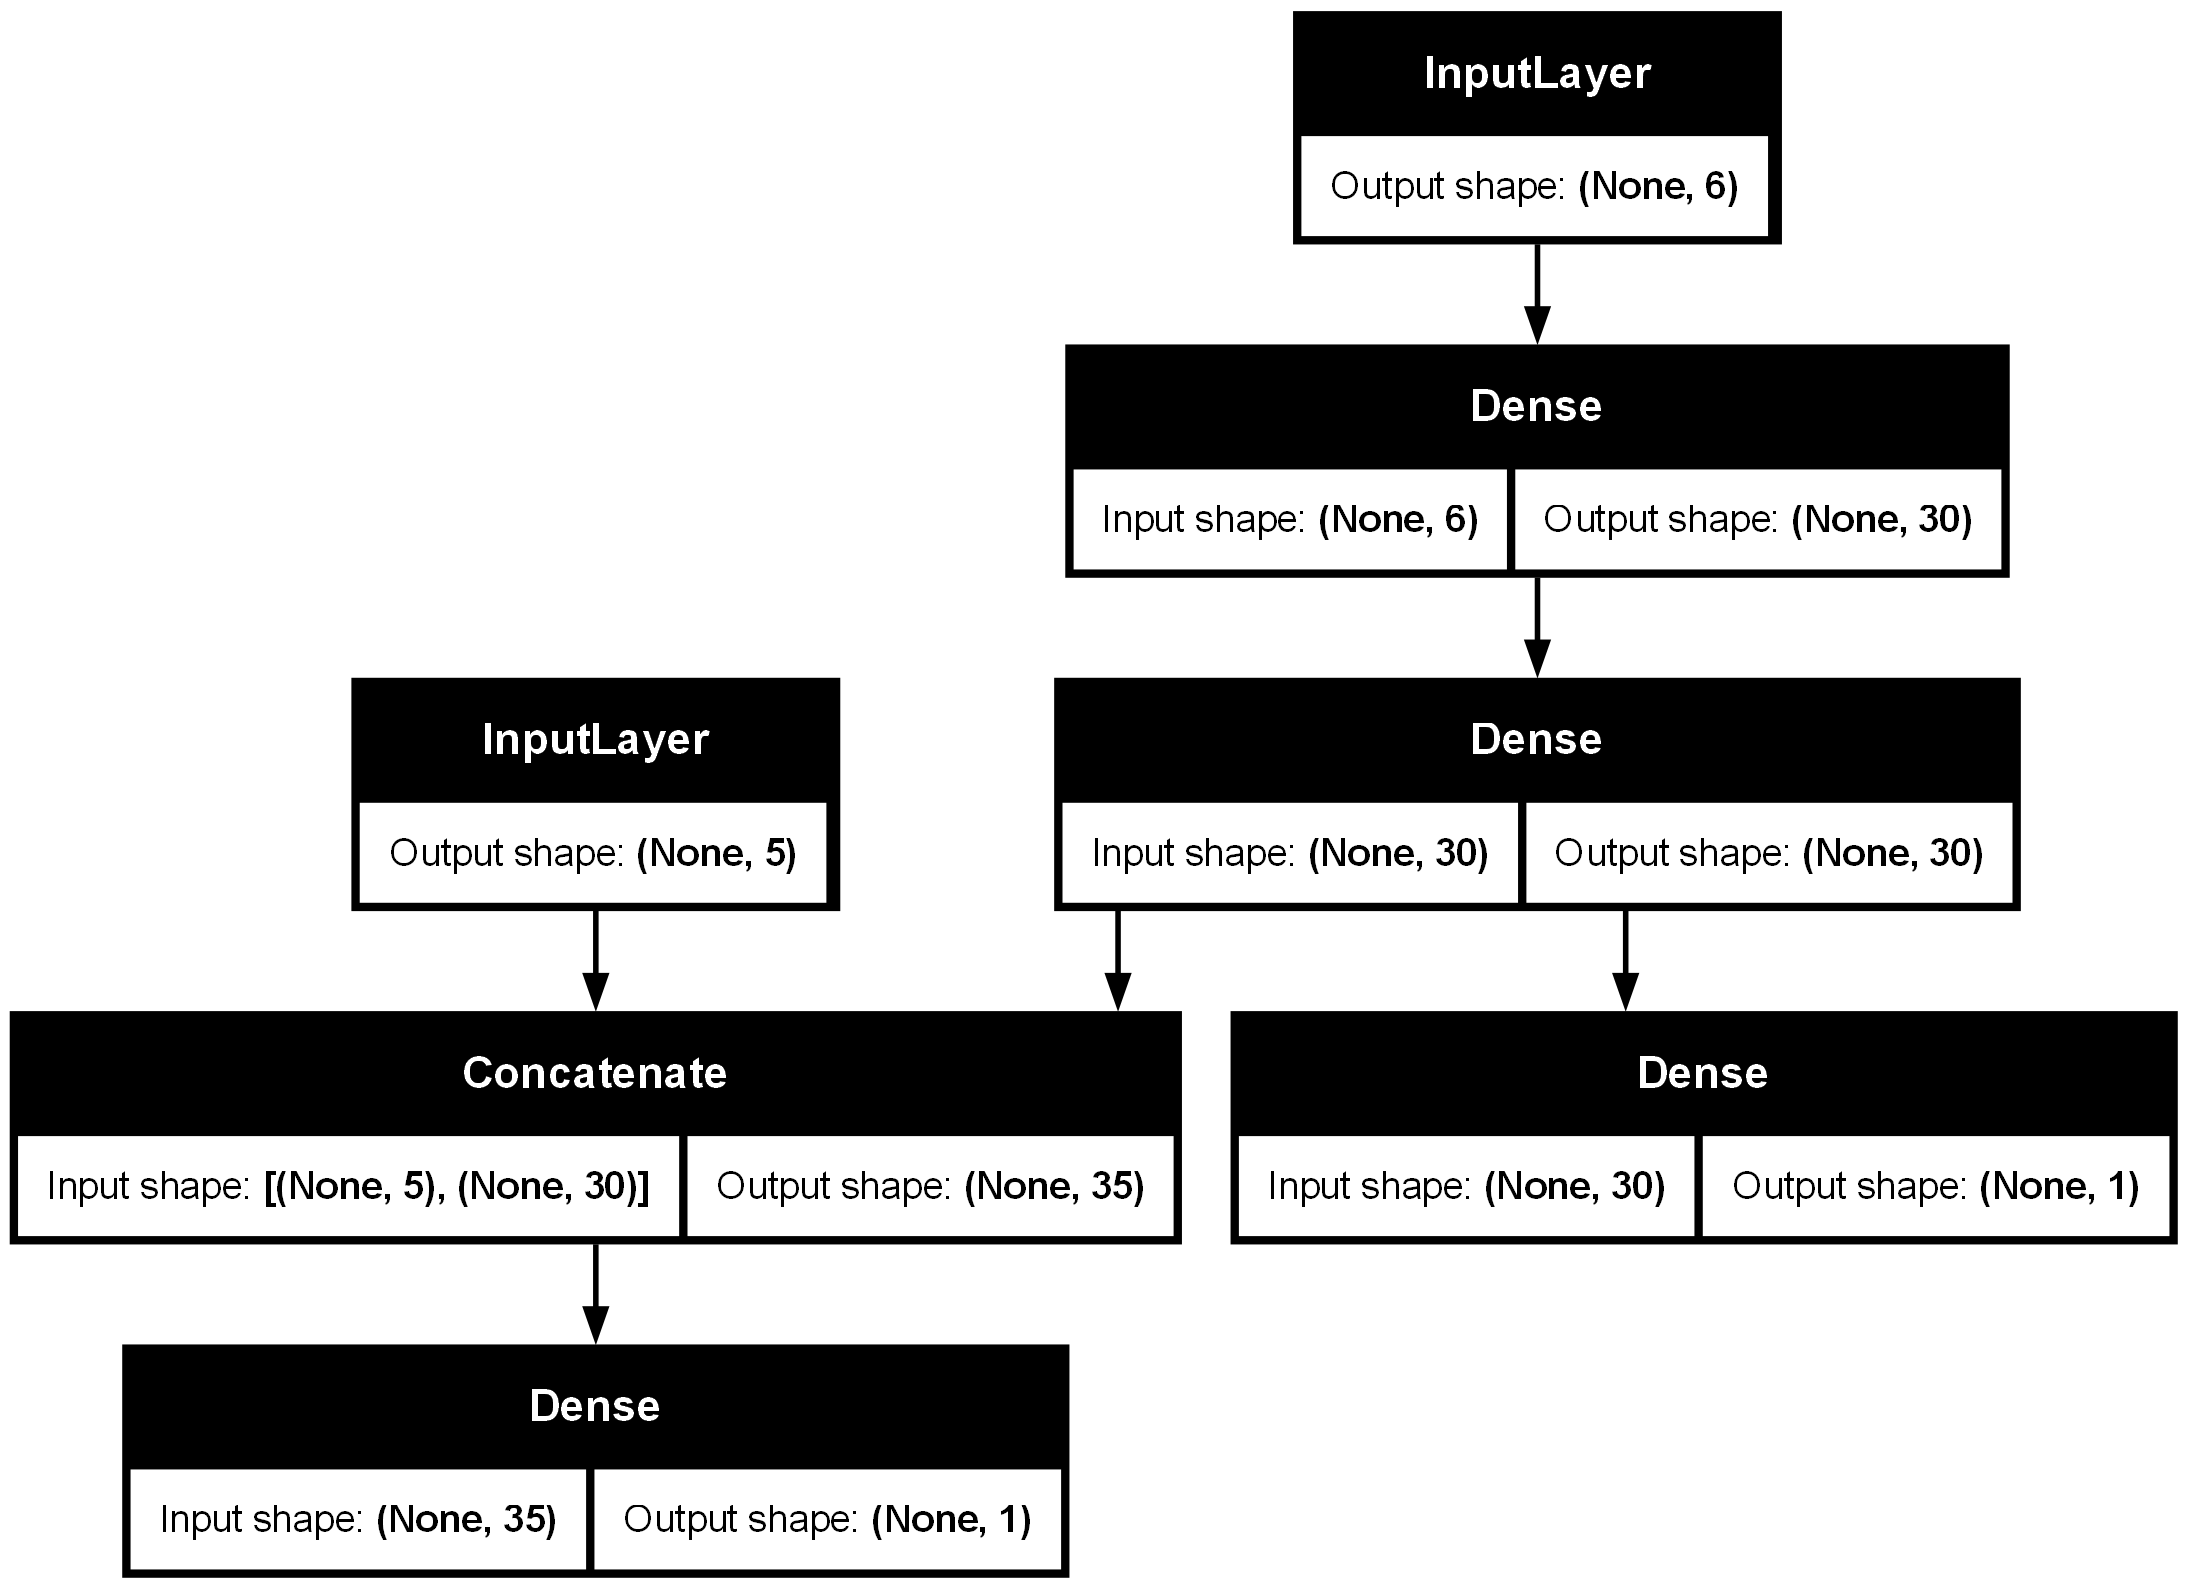

In [54]:
keras.utils.plot_model(model, "multiple_outputs_NN.png", show_shapes=True)

In [55]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - aux_output_loss: 4.7471 - loss: 3.1459 - main_output_loss: 2.9680 - val_aux_output_loss: 4.3843 - val_loss: 1.1462 - val_main_output_loss: 0.7862
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 2.8670 - loss: 0.9977 - main_output_loss: 0.7900 - val_aux_output_loss: 5.3881 - val_loss: 1.1634 - val_main_output_loss: 0.6937
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 2.1751 - loss: 0.8564 - main_output_loss: 0.7099 - val_aux_output_loss: 5.5660 - val_loss: 1.1156 - val_main_output_loss: 0.6207
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 1.8353 - loss: 0.7810 - main_output_loss: 0.6639 - val_aux_output_loss: 5.2150 - val_loss: 1.0460 - val_main_output_loss: 0.5824
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 1.6511 - loss: 0.7314 - main_output_loss: 0.6292 - val_aux_output_loss: 4.5219 - val_loss: 0.9499 - val_main_output_loss: 0.5527


In [56]:
# Each output has its own loss function - for compilation need a list of losses
# - if only one Keras will think all of htem have the same
# Keras will compute all losses and simply add them to get the final loss used for training
# - we care much more about the main output's loss so we give it a greater weight

In [57]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - aux_output_loss: 0.9710 - loss: 0.4920 - main_output_loss: 0.4388
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [58]:
y_pred_main

array([[0.39816585],
       [1.9226065 ],
       [3.073669  ]], dtype=float32)

In [59]:
# The subclassing API
# - API is declarative - easy for saving, cloning, sharing, analysing, displaying
# - downside - it is static graph of layers but some models involve loops, varying shapres, conditional branching ...
# ---> for this subclassing API can be used

In [60]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [61]:
# Looks similar to Functional API - but not need to create the inpts - just use input argument to call() method
# with this you can do anything you want in the loop method - loops, if statements, tensorFlow operations...
# - great for researches experimenting with new ideas

In [63]:
# Saving and Restoring
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.9474 - val_loss: 1.0241
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9230 - val_loss: 0.6703
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7144 - val_loss: 0.6062
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6691 - val_loss: 0.5703
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6336 - val_loss: 0.5403
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6023 - val_loss: 0.5148
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5746 - val_loss: 0.4934
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5503 - val_loss: 0.4764
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5290 - val_loss: 0.4594
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5099 - val_loss: 0.4477
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4840


In [66]:
model.save("my_model.keras")

In [67]:
model = keras.models.load_model("my_model.keras")
model.predict(X_new)
# Works for sequential and functional API
# for Model subclassing - can use save_weights() and load_weights() to restore model parameters
# everything else you need to save yourself


C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([[0.99835235],
       [1.600403  ],
       [2.8749847 ]], dtype=float32)

In [69]:
model.save_weights("my_keras.weights.h5")

In [70]:
model.load_weights("my_keras.weights.h5")

In [71]:
# Using Callbacks during traingin - fit() method accepts this argument
# - can call it during training, at the start and end of training, at the start and end of each epoch
# - even before and after processing of each batch
# - e.g. ModelCheckpoint callback - saves checkpoints of the model at regular intervals during training
#        by default at the end of each epoch

In [72]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [76]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.keras", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_model.keras") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.0836 - val_loss: 1.1484
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8189 - val_loss: 0.6914
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7158 - val_loss: 0.6261
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6635 - val_loss: 0.5853
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6245 - val_loss: 0.5559
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5938 - val_loss: 0.5336
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5687 - val_loss: 0.5155
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5473 - val_loss: 0.5009
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5287 - val_loss: 0.4882
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5124 - val_loss: 0.4779
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4769


In [77]:
# With ModelCheckpoint you can save your model when the performance on the validation set is best so far
# - no need to worry about training for too long and overfitting, simply restore to the last saved model after training
# - easy to implement early stopping:

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4982 - val_loss: 0.4703
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4858 - val_loss: 0.4637
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4748 - val_loss: 0.4579
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4650 - val_loss: 0.4529
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4565 - val_loss: 0.4488
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4489 - val_loss: 0.4448
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4421 - val_loss: 0.4420
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4360 - val_loss: 0.4391
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4305 - val_loss: 0.4366
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4255 - val_loss: 0.4341
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4209 - val_loss: 0.4312
Epoch 12/100
363/363 ━━━━━━━━━━━━━━━━━━━━

In [79]:
# EarlyStopping will keep track of the best weights and restore them for us at the end of training
# For more control, one can write your own custom calbacks as well:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [80]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

354/363 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3376
val/train: 1.10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3373 - val_loss: 0.3603


In [81]:
# Visualizing using TensorBoard
# - learning curves, caparison between multiple runs, computation graph, training statistics, ...
# - data needs to be in binary log file called event file - each data record is called a summary
# - TensorBoard server monitors the log directory and will automatically pick up changes and update visualizations

In [82]:
# Create root directory
root_logdir = os.path.join(os.curdir, "my_logs")

In [83]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2025_11_20-11_29_22'

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [87]:
# TensorBoard callback:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2043 - val_loss: 1.8442
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9227 - val_loss: 0.8574
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7555 - val_loss: 0.6943
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6906 - val_loss: 0.5908
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6473 - val_loss: 0.5693
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6126 - val_loss: 0.5304
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5832 - val_loss: 0.5075
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5579 - val_loss: 0.4880
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5360 - val_loss: 0.4742
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5169 - val_loss: 0.4633
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5003 - val_loss: 0.4537
Epoch 12/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [ ]:
# Now need to start the TensorBoard Server